In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from crypto_bot.utils import save_obj, load_obj
from crypto_bot.binance.data_utils import download_data, load_dataframe
from crypto_bot.model.data import BinaryTradeDataset, MulticlassTradeDataset

DATA_FOLDER = 'C:/Users/diego/crypto_bot/data'
WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download data

In [ ]:
download_data(DATA_FOLDER, startDate='2020-01-01', endDate='2022-01-01', intervals=['1h'])

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-01.zip

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-02.zip


# Load data

In [4]:
train_df = load_dataframe(DATA_FOLDER, '2020-01-01', '2021-10-30', interval='1h')
valid_df = load_dataframe(DATA_FOLDER, '2021-11-01', '2021-12-30', interval='1h')

In [6]:
train_df.shape

(16050, 12)

# Prepare data

In [10]:
from crypto_bot.model.transforms import FilterFeatures, RelativeTransform, ManualNormalizer, ToTensorTransform
from sklearn.pipeline import Pipeline
from crypto_bot.model.data import MulticlassTradeDataset

features = ['Open', 'High', 'Low', 'Close', 'Volume']
transforms = Pipeline([
    ('filter_features', FilterFeatures(features)),
    ('relative_features', RelativeTransform('Close', ['Open', 'High', 'Low', 'Close'])),
    ('normalize_volume', ManualNormalizer('Volume', 253.104670, 294.186058)),
    ('to_tensor', ToTensorTransform()),
])

## Binary/Multiclass dataset

In [11]:
# Binary
train_dataset = BinaryTradeDataset(train_df, transforms, 0.8, stride=3)
valid_dataset = BinaryTradeDataset(valid_df, transforms, 0.8, stride=3)

# # Multiclass
# train_dataset = MulticlassTradeDataset(train_df, transforms, 0.7, -0.3, stride=1)
# valid_dataset = MulticlassTradeDataset(valid_df, transforms, 0.7, -0.3, stride=1)

train_dataset.precompute()
valid_dataset.precompute()

In [14]:
train_ds_name = '{}/data_loaders/train_5m_v1.ds'.format(DATA_FOLDER)
valid_ds_name = '{}/data_loaders/valid_5m_v1.ds'.format(DATA_FOLDER)

# Save
save_obj(train_ds_name, train_dataset)
save_obj(valid_ds_name, valid_dataset)

# # Load
# train_dataset = load_obj(train_ds_name)
# valid_dataset = load_obj(valid_ds_name)

# Load data

In [4]:
ds = load_dataframe(DATA_FOLDER, start_date='2021-12-01', end_date='2021-12-30', interval='5m')

In [5]:
ds.shape

(8928, 12)

In [6]:
ds.head()

,Date,Open,High,Low,Close,Volume,close_date,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2021-12-01 00:00:00,56950.56,57011.08,56630.00,56813.62,291.49974,2021-12-01 00:04:59.999,1.655456e+07,8145,155.51948,8.829755e+06,0
1,2021-12-01 00:05:00,56813.63,57236.12,56776.60,57134.00,161.20866,2021-12-01 00:09:59.999,9.204743e+06,5809,92.44872,5.278843e+06,0
2,2021-12-01 00:10:00,57132.60,57530.96,57122.98,57198.47,239.27765,2021-12-01 00:14:59.999,1.372364e+07,7435,114.00459,6.541762e+06,0
3,2021-12-01 00:15:00,57189.66,57435.50,57189.66,57408.01,207.41464,2021-12-01 00:19:59.999,1.188887e+07,4765,116.52493,6.679587e+06,0
4,2021-12-01 00:20:00,57408.00,57440.59,57334.36,57410.00,86.32988,2021-12-01 00:24:59.999,4.954712e+06,3590,40.84212,2.344121e+06,0


In [20]:
from crypto_bot.model.transforms import BaseTransform
from talib.abstract import Function


class TalibTransform(BaseTransform):
    # https://github.com/mrjbq7/ta-lib
    OPEN = 'Open'
    HIGH = 'High'
    LOW = 'Low'
    CLOSE = 'Close'
    VOLUME = 'Volume'

    def __init__(self, func_name, output_name, **kwargs):
        self.func_name = func_name
        self.output_name = output_name
        self.kwargs = kwargs
        self.f = Function(func_name)
    
    def transform(self, X):
        inputs = {
            'open': X[self.OPEN],
            'high': X[self.HIGH],
            'low': X[self.LOW],
            'close': X[self.CLOSE],
            'volume': X[self.VOLUME]
        }
        X[self.output_name] = self.f(inputs, **self.kwargs)
        return X
        

In [13]:
Function('EMA')

{'name': 'EMA', 'group': 'Overlap Studies', 'display_name': 'Exponential Moving Average', 'function_flags': ['Output scale same as input', 'Function has an unstable period'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 30)]), 'output_flags': OrderedDict([('real', ['Line'])]), 'output_names': ['real']}

In [21]:
transform = TalibTransform('EMA', 'ema_30', timeperiod=30)

In [24]:
ds = transform.fit_transform(ds)

In [25]:
ds.head()

,Date,Open,High,Low,Close,Volume,close_date,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,ema_30
0,2021-12-01 00:00:00,56950.56,57011.08,56630.00,56813.62,291.49974,2021-12-01 00:04:59.999,1.655456e+07,8145,155.51948,8.829755e+06,0,NaN
1,2021-12-01 00:05:00,56813.63,57236.12,56776.60,57134.00,161.20866,2021-12-01 00:09:59.999,9.204743e+06,5809,92.44872,5.278843e+06,0,NaN
2,2021-12-01 00:10:00,57132.60,57530.96,57122.98,57198.47,239.27765,2021-12-01 00:14:59.999,1.372364e+07,7435,114.00459,6.541762e+06,0,NaN
3,2021-12-01 00:15:00,57189.66,57435.50,57189.66,57408.01,207.41464,2021-12-01 00:19:59.999,1.188887e+07,4765,116.52493,6.679587e+06,0,NaN
4,2021-12-01 00:20:00,57408.00,57440.59,57334.36,57410.00,86.32988,2021-12-01 00:24:59.999,4.954712e+06,3590,40.84212,2.344121e+06,0,NaN


In [37]:
from crypto_bot.model.data import plot_by_date, plot_by_idx, plot_df_interactive

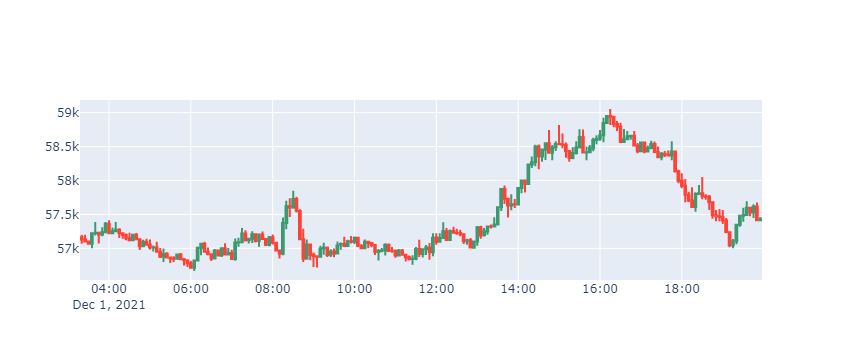

In [41]:
fig = plot_df_interactive(ds[40:240])
fig.show()

In [1]:
# fig.show()

In [31]:
help(fig.add_traces)

Help on method add_traces in module plotly.basedatatypes:

add_traces(data, rows=None, cols=None, secondary_ys=None, exclude_empty_subplots=False) method of plotly.graph_objs._figure.Figure instance
    Add traces to the figure
    
    Parameters
    ----------
    data : list[BaseTraceType or dict]
        A list of trace specifications to be added.
        Trace specifications may be either:
    
          - Instances of trace classes from the plotly.graph_objs
            package (e.g plotly.graph_objs.Scatter, plotly.graph_objs.Bar)
          - Dicts where:
    
              - The 'type' property specifies the trace type (e.g.
                'scatter', 'bar', 'area', etc.). If the dict has no 'type'
                property then 'scatter' is assumed.
              - All remaining properties are passed to the constructor
                of the specified trace type.
    
    rows : None, list[int], or int (default None)
        List of subplot row indexes (starting from 1) for the

In [30]:
dir(fig)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_annotation_like',
 '_allow_disable_validation',
 '_animation_duration_validator',
 '_animation_easing_validator',
 '_batch_layout_edits',
 '_batch_trace_edits',
 '_bracket_re',
 '_build_dispatch_plan',
 '_build_update_params_from_batch',
 '_config',
 '_data',
 '_data_defaults',
 '_data_objs',
 '_data_validator',
 '_dispatch_layout_change_callbacks',
 '_dispatch_trace_change_callbacks',
 '_filter_by_selector',
 '_frame_objs',
 '_frames_validator',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_get_subplot_coordinates',
 '_get_subplot_rows_columns',
 

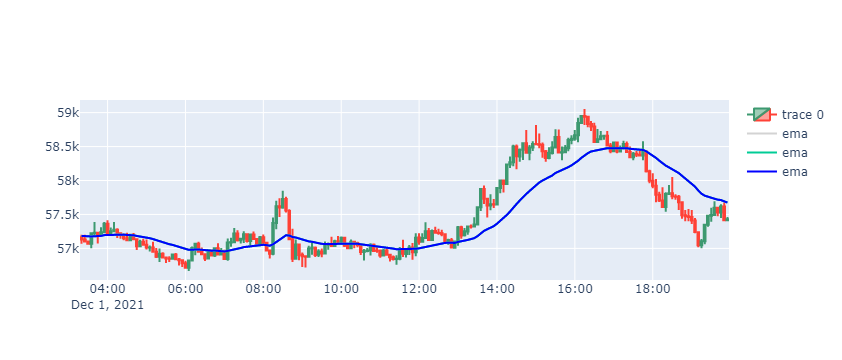

In [44]:
import plotly.graph_objects as go

fig.add_trace(go.Scatter(
    x=ds[40:240]['Date'], 
    y=ds[40:240]['ema_30'],
    type='scatter', 
    mode='lines',
    line=dict(color='blue'),
    name='ema'
))

## BBANDS - Bollinger Bands
Rango en los cuales se mueve el precio (media y desviaciones)
Por debajo de la banda inferior puede indicar subida, por encima puede indicar bajada

## DEMA - Double Exponential Moving Average
https://www.daytradetheworld.com/trading-blog/double-exponential-moving-average-dema/
Indicador de tendencia. Precios por encima de la DEMA ayudan a confirmar up trend, por debajo confirman down-trend.
Usar 2, una short term y otro long term. Cuando se cruzan puede indicar reversal.

## EMA - Exponential Moving Average
Indicador de tendencia, cruces del precio con la EMA pueden indicar reversal.

## HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
?

## KAMA - Kaufman Adaptive Moving Average
Otro indicador de tendencia. Controlar cruces.

## MA - Moving average
..

## MAMA - MESA Adaptive Moving Average
..

## SAREXT -Parabolic SAR - Extended
## SMA -Simple Moving Average
?